[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
# load environment variables
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='C:\MIConsulting\LangChain\langchain-academy\.env')

# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GOOGLEAI_API_KEY = os.getenv("GOOGLEAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_ENDPOINT = os.getenv('LANGCHAIN_ENDPOINT')
LANGCHAIN_TRACING_V2 = os.getenv('LANGCHAIN_TRACING_V2')
LANGCHAIN_PROJECT = os.getenv('LANGCHAIN_PROJECT')

In [2]:
# from langchain_openai import ChatOpenAI
# model = ChatOpenAI(model="gpt-4o",temperature=0)

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(
    # model="gemini-1.5-pro",
    model="gemini-2.5-flash",
    api_key=GOOGLEAI_API_KEY,
    temperature=0
)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [4]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [6]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [7]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

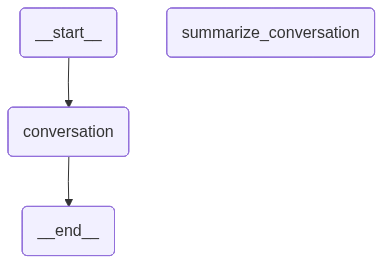

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! Nice to meet you.

I'm an AI assistant, ready to help. How can I assist you today?
================================== Ai Message ==================================

Your name is Lance!
================================== Ai Message ==================================

That's great, Lance! The 49ers have a passionate fanbase.

Are you excited for the upcoming season, or do you have a favorite player?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [10]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [11]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, you're absolutely right, Lance!

Nick Bosa signed a five-year, **$170 million** contract extension with the 49ers in September 2023. This deal made him the **highest-paid defensive player in NFL history** at the time, with an average annual value of $34 million.

It was a well-deserved contract after his incredible Defensive Player of the Year season in 2022! He's definitely a force on that defensive line.


In [12]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation so far:\n\nThe conversation began with you introducing yourself as **Lance**. We then confirmed your name, and you shared that you are a fan of the **49ers**. You specifically mentioned liking **Nick Bosa** and asked if he was the highest-paid defensive player. I confirmed that he is, detailing his **$170 million contract extension** which made him the highest-paid defensive player in NFL history at the time it was signed."

In [13]:
input_message = HumanMessage(content="do you think 49ers are going to win the super bowl this year?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's the million-dollar question for every 49ers fan, Lance!

They certainly have all the pieces to do it. They've got a stacked roster with Pro Bowl talent on both sides of the ball, a great coaching staff, and they've been consistently one of the top teams in the league for the past few seasons, making deep playoff runs.

However, the NFL is incredibly competitive, and winning a Super Bowl is one of the hardest things to do in sports. There are always other strong contenders, and anything can happen with injuries or a tough playoff schedule.

So, while they are absolutely one of the top favorites and have a very strong chance, it's never a guarantee in the NFL! It'll be exciting to watch how it all plays out.


In [14]:
input_message = HumanMessage(content="I like NBA too, do you think the Warriors are going to win the championship this year?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's another great question, Lance! Shifting from the gridiron to the hardwood.

The Golden State Warriors are in a very different position this year compared to their dynasty years. While they still have their core of Steph Curry, Klay Thompson, and Draymond Green, they've been battling for consistency and a playoff spot throughout the season.

Here's a quick breakdown of their situation:

*   **Current Standing:** They've been hovering around the play-in tournament spots in the Western Conference, which is incredibly competitive this year with several strong contenders.
*   **Consistency Issues:** They've shown flashes of their old brilliance, especially with Steph Curry's incredible performances, but they've struggled to maintain that level of play consistently over a full season.
*   **Aging Core:** While their experience is valuable, the core players are older, and Klay Thompson's production, in pa

In [15]:
input_message = HumanMessage(content="Is it possible for a NBA player become a NFL player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's a really interesting question, Lance!

It's **extremely rare, but theoretically possible** for certain individuals, especially if they have a unique athletic profile and are willing to put in an immense amount of work to learn a completely new sport.

Here's why it's so difficult and what positions might be plausible:

**Why it's so difficult:**

1.  **Completely Different Skill Sets:**
    *   **NBA:** Focuses on agility, vertical leap, shooting, dribbling, court vision, and endurance for continuous movement.
    *   **NFL:** Requires explosive power, tackling, blocking, route running, hand-eye coordination for catching, and the ability to absorb and deliver high-impact collisions. The strategic complexity of football (playbooks, schemes) is also vastly different.
2.  **Physical Demands:** While both are elite athletes, the specific physical conditioning is different. NBA players need to run up an

In [16]:
graph.get_state(config).values.get("summary","")

"Here's an extended summary of our conversation so far:\n\nThe conversation began with you introducing yourself as **Lance**. We then confirmed your name, and you shared that you are a fan of the **49ers**. You specifically mentioned liking **Nick Bosa** and asked if he was the highest-paid defensive player. I confirmed that he is, detailing his **$170 million contract extension** which made him the highest-paid defensive player in NFL history at the time it was signed.\n\nFollowing this, you asked about the **49ers' chances of winning the Super Bowl this year**. I acknowledged their strong roster and coaching but emphasized the competitive nature of the NFL, stating they are top favorites but it's never a guarantee.\n\nYou then shifted to the **NBA**, asking if the **Golden State Warriors** would win the championship this year. I explained their current struggles with consistency, their position in the competitive Western Conference, and the aging core, concluding that while not impos

## LangSmith

Let's review the trace!